# Melk: What happens here?
Based on pymc-marketing example notebook (02_mmm_example.ipynb)

## Changes
- Make adstock and saturation almost vanish in simulated data (but keep code for later)
- Remove dayofweek
- Add confounder x1 (FB) to x2 (Google)
- Do own model for that by hand

In [321]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.delayed_saturated_mmm import MMM
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

from utils03 import MelkConfounder

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/workspaces/mmm_experiments/mmm/fbgoogle/utils03.py:146: SyntaxWarning: invalid escape sequence '\%'
  )
/workspaces/mmm_experiments/mmm/fbgoogle/utils03.py:225: SyntaxWarning: invalid escape sequence '\%'
  )


In [322]:
LOAD_FROM_DISK = False
# set filename to current filename
model_name = "03_mmm_example.savedmodel"

## Generate Data

### 1. Date Range

First we set a time range for our data. We consider a bit more than 2 years of data at weekly granularity.

In [323]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2024-01-01")
max_date = pd.to_datetime("2024-05-30")

df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="D")}
).assign(
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    dayofyear=lambda x: x["date"].dt.dayofyear,
    dayofweek=lambda x: x["date"].dt.dayofweek, # Monday=0, Sunday=6
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 151


In [324]:
true_values = {
    "beta_y0": 1.5,
    "sigma_y" : 0.05,
    # "beta_fb_0": 2.0, # defined post simulated data
    "beta_fb_y": 1.0,
    # "beta_fb_sem": 0.3,
    # "beta_sem_0": 0.3, # defined post simulated data
    # "beta_sem_y": 0.6,
}

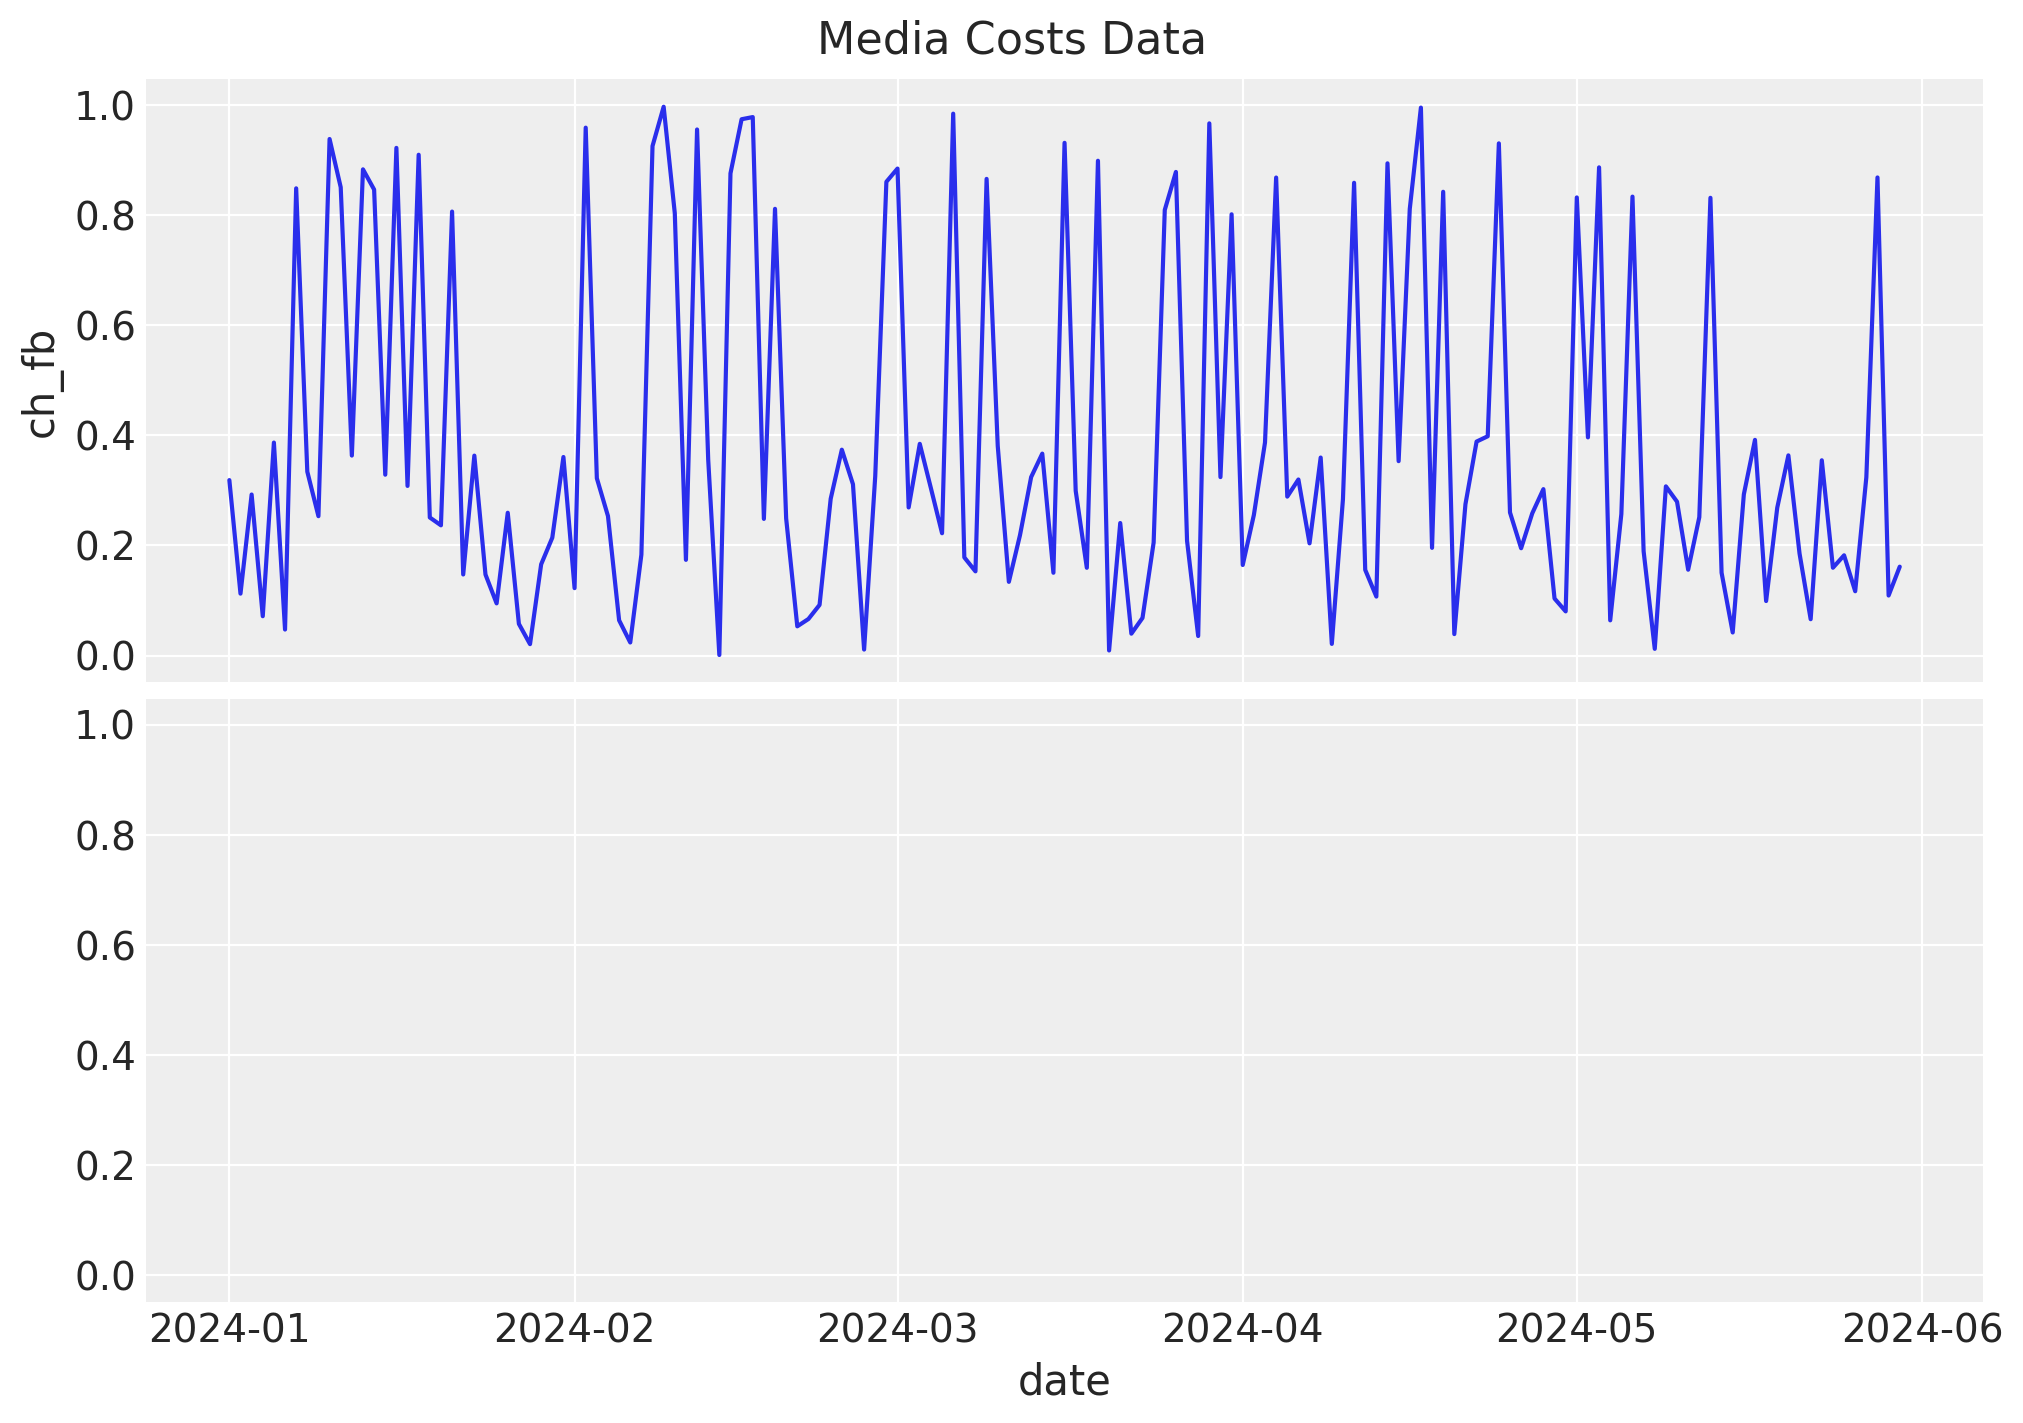

In [325]:
# media spend data  Facebook
ch_fb_rnd = rng.uniform(low=0.0, high=1.0, size=n)
df["ch_fb"] = np.where(ch_fb_rnd > 0.8, ch_fb_rnd, ch_fb_rnd / 2)

# media spend for X2 - Google. Gets a confounding boost from X1.
# sem_0_rnd = rng.uniform(low=0.1, high=1.0, size=n)
# sem_own = sem_0_rnd 

# sem_from_fb = df["ch_fb"] * true_values["beta_fb_sem"]
# df["ch_sem"] = sem_own + sem_from_fb
# df["ch_sem"] = sem_own 

# infer "true values" for the last parameters to compare with the posterior predictive distributions
# true_values["beta_fb_0"] = df["ch_fb"].mean() 
# true_values["beta_sem_0"] = sem_own.mean()

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date", y="ch_fb", data=df, color="C0", ax=ax[0])
# sns.lineplot(x="date", y="ch_sem", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

We can now visualize the effect signal for each channel after each transformation:

### 3.1 Weekday Components

In [326]:
# Extra sales on Mon to Sat - Sun is the base and goes into intercept
dow_gamma_true = [1.0, 0.3, 0.3, 0.5, 0.3, 0.3]

def add_dayofweek(df: pd.DataFrame) -> pd.DataFrame:
    df["dayofweek"] = df.assign(dayofweek=lambda x: x["date"].dt.dayofweek)["dayofweek"]
    for dayofweek in range(6):
        df[f"dayofweek_{dayofweek}"] = np.where(df["dayofweek"] == dayofweek, 1, 0)
    return df

# add columns for day of week
df = add_dayofweek(df)

# define list of dayofweek variables for later use
control_dayofweek = [f"dayofweek_{dayofweek}" for dayofweek in range(6)]

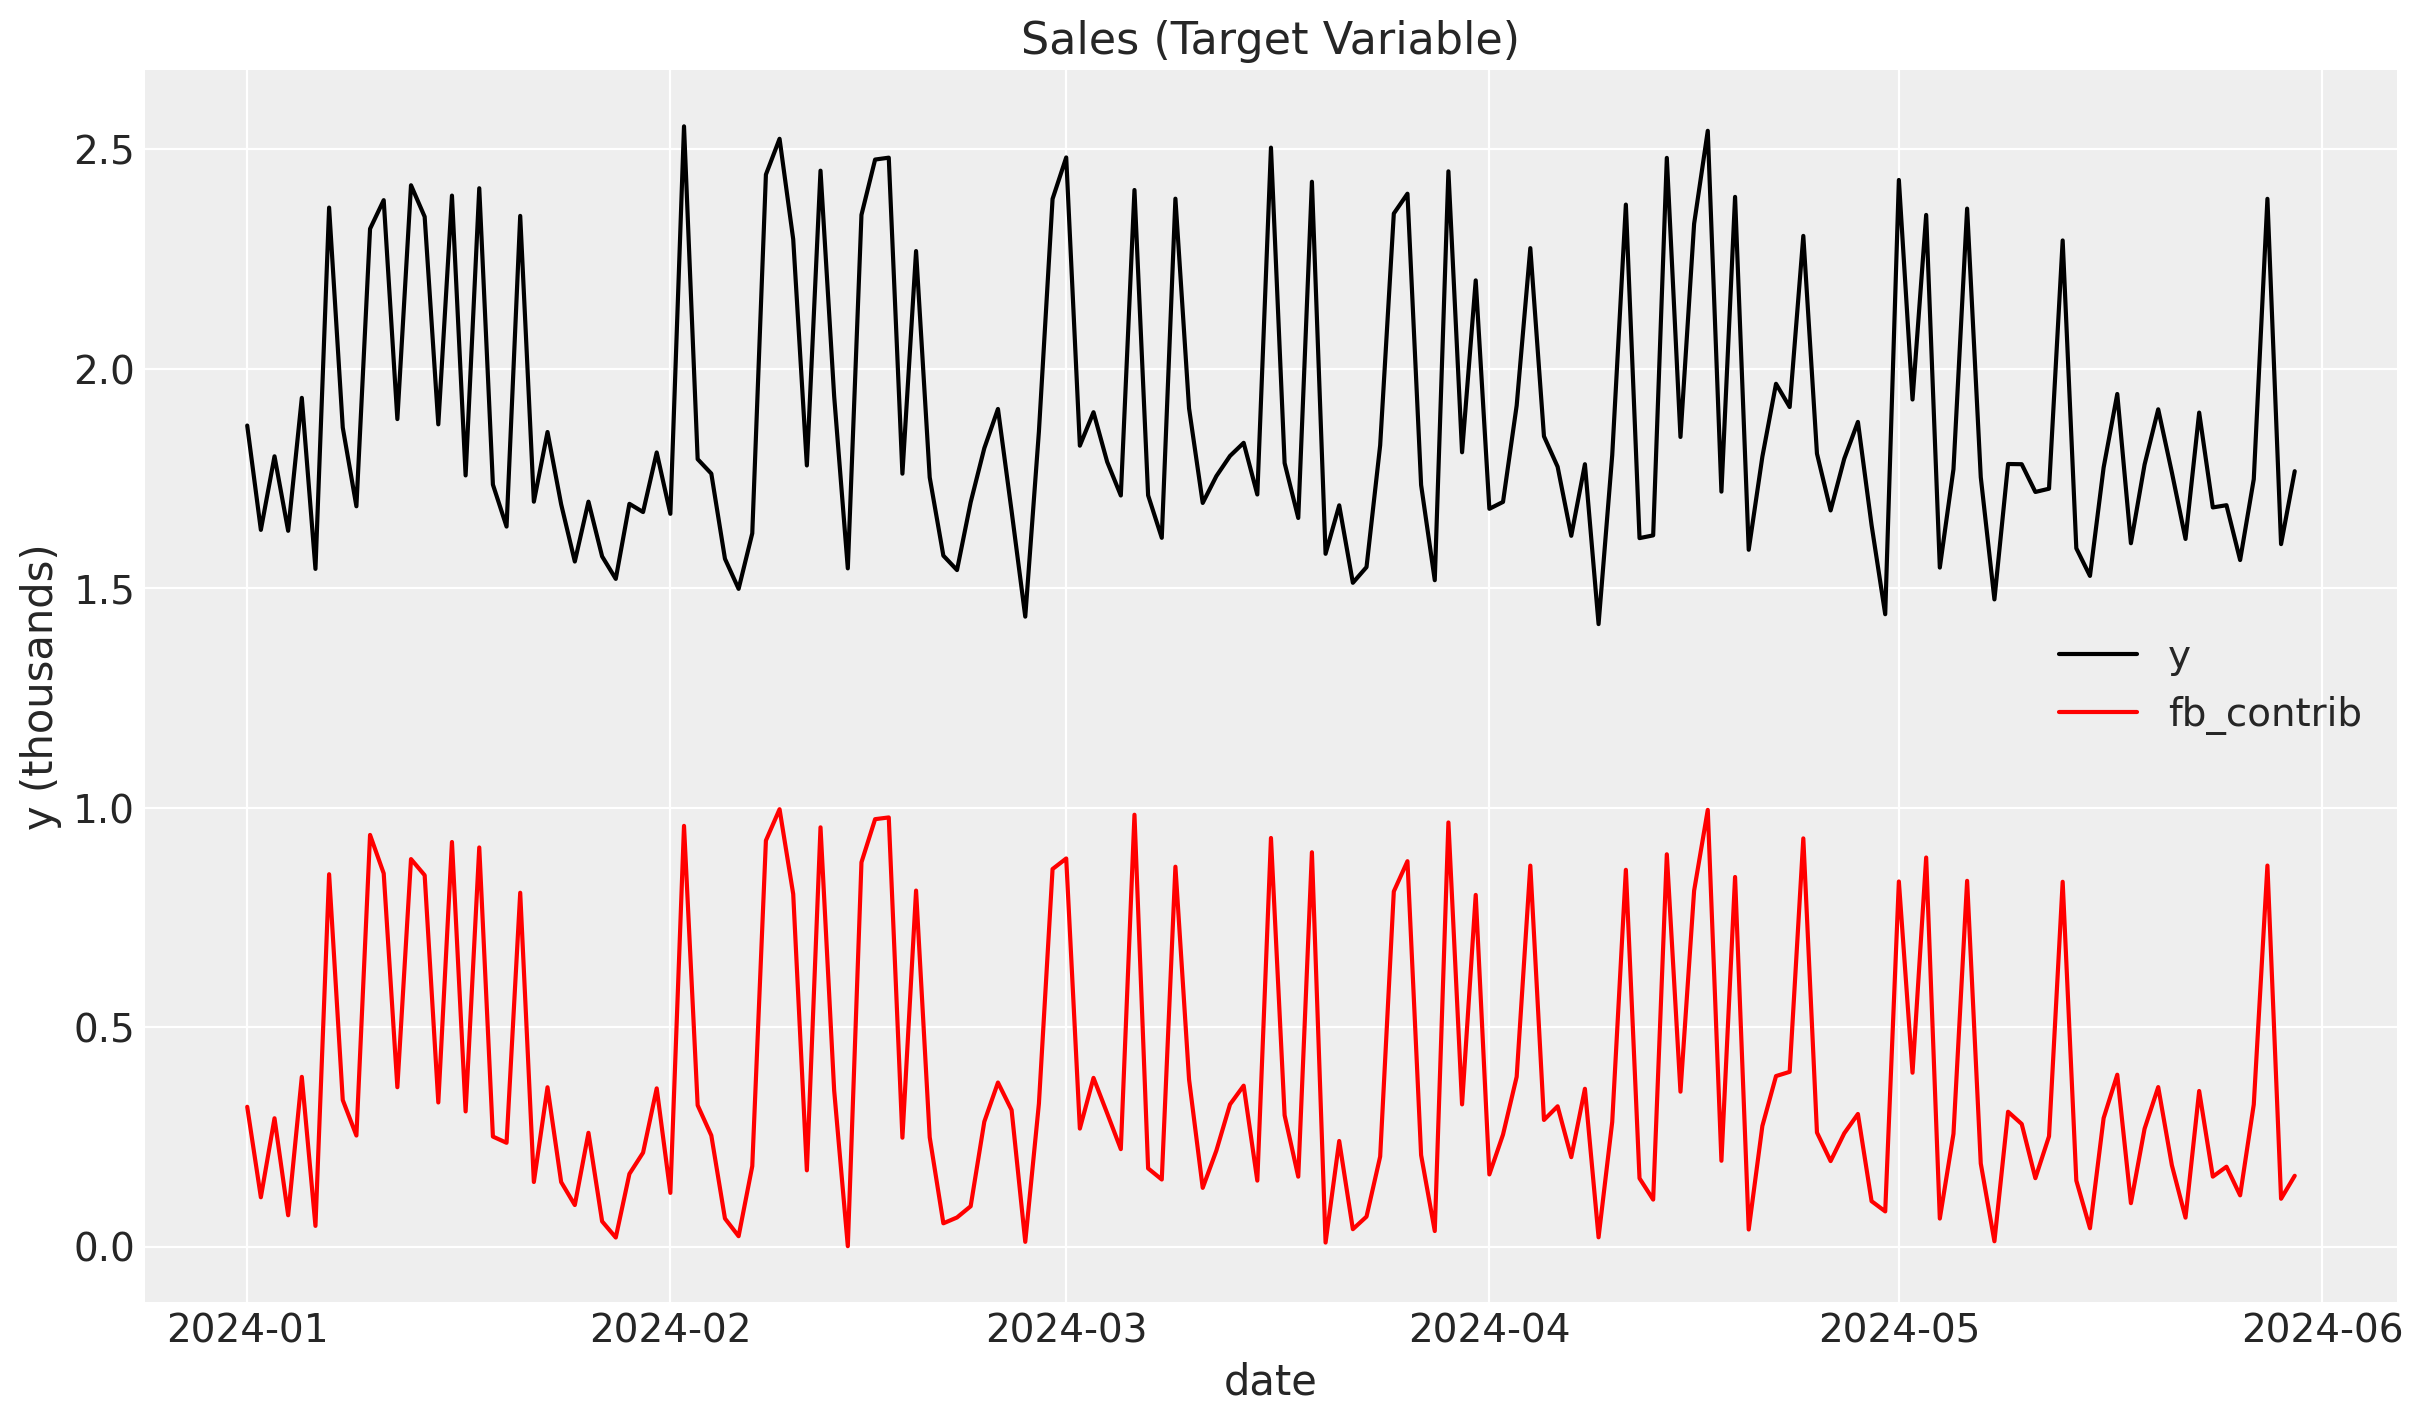

In [327]:
df["intercept"] = true_values["beta_y0"]
df["epsilon"] = rng.normal(loc=0.0, scale=true_values["sigma_y"], size=n)

df["fb_contrib"] = df["ch_fb"] * true_values["beta_fb_y"]

df["y"] = (
    df["intercept"] + 
    df["epsilon"] +
    df["fb_contrib"] 
    # df["ch_sem"] * true_values["beta_sem_y"] 
) 
# add day of week effect
df["dayofweek_effect"] = df["y"] * 0
for dayofweek in range(6):
    effect = df[f"dayofweek_{dayofweek}"] * dow_gamma_true[dayofweek] 
    df["dayofweek_effect"] = df["dayofweek_effect"] + effect

# df["y"] = df["y"] + df["dayofweek_effect"]

fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", data=df, ax=ax, label="y")
sns.lineplot(x="date", y="fb_contrib", color="red", data=df, ax=ax, label="fb_contrib")
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

In [328]:
# # correlation of media spend with sales
# corr = df[["ch_sem", "ch_fb", "y"]].corr()
# fig, ax = plt.subplots()
# fig.set_size_inches(3, 3)
# sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)

### 7. Data Output

We of course will not have all of these features in our real data. Let's filter out the features we will use for modeling:

In [329]:
columns_to_keep = [
    "date",
    "y",
    "ch_fb",
    # "ch_sem",
] 

data = df[columns_to_keep].copy()

data

,date,y,ch_fb
0,2024-01-01,1.870960,0.318580
1,2024-01-02,1.633228,0.112388
2,2024-01-03,1.800854,0.292400
3,2024-01-04,1.631105,0.071399
4,2024-01-05,1.933996,0.386745
...,...,...,...
146,2024-05-26,1.564493,0.116747
147,2024-05-27,1.748652,0.323780
148,2024-05-28,2.387582,0.868246
149,2024-05-29,1.600753,0.108988


## Part II: Modeling

On this second part, we focus on the modeling process. We will use the data generated in Part I.

## 2. Model Specification

Next, we specify the `sigma` parameter per channel: 

## 3. Model Fitting

Create the mmm model:

In [330]:
mmm = MelkConfounder(data, true_values, datevarname="date")

Fit the model and show the graph

In [331]:
mmm.define_model()  
mmm.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_fb_y, beta_y0, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [y_obs]


Output()

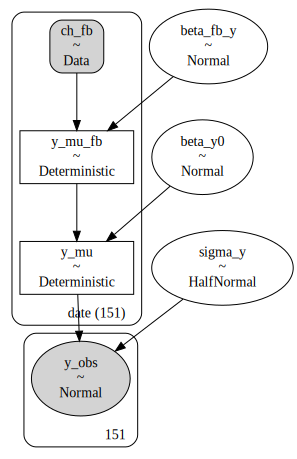

In [332]:
pm.model_to_graphviz(model=mmm.model)

In [333]:
mmm.idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [334]:
mmm.idata.posterior

<xarray.Dataset> Size: 10MB
Dimensions:    (chain: 4, draw: 1000, date: 151)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * date       (date) datetime64[ns] 1kB 2024-01-01 2024-01-02 ... 2024-05-30
Data variables:
    beta_fb_y  (chain, draw) float64 32kB 1.002 1.002 0.9988 ... 1.0 1.01 1.015
    beta_y0    (chain, draw) float64 32kB 1.511 1.511 1.506 ... 1.502 1.496
    sigma_y    (chain, draw) float64 32kB 0.04874 0.05439 ... 0.05469 0.05392
    y_mu       (chain, draw, date) float64 5MB 1.831 1.624 1.804 ... 1.606 1.659
    y_mu_fb    (chain, draw, date) float64 5MB 0.3193 0.1126 ... 0.1106 0.1638
Attributes:
    created_at:                 2024-06-18T20:31:27.631729+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1
    sampling_time:              10.648337841033936
    tuning_steps:               1000

In [335]:
# mmm.idata.posterior_predictive

In [336]:
true_values

{'beta_y0': 1.5, 'sigma_y': 0.05, 'beta_fb_y': 1.0}

/tmp/ipykernel_985489/533560589.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


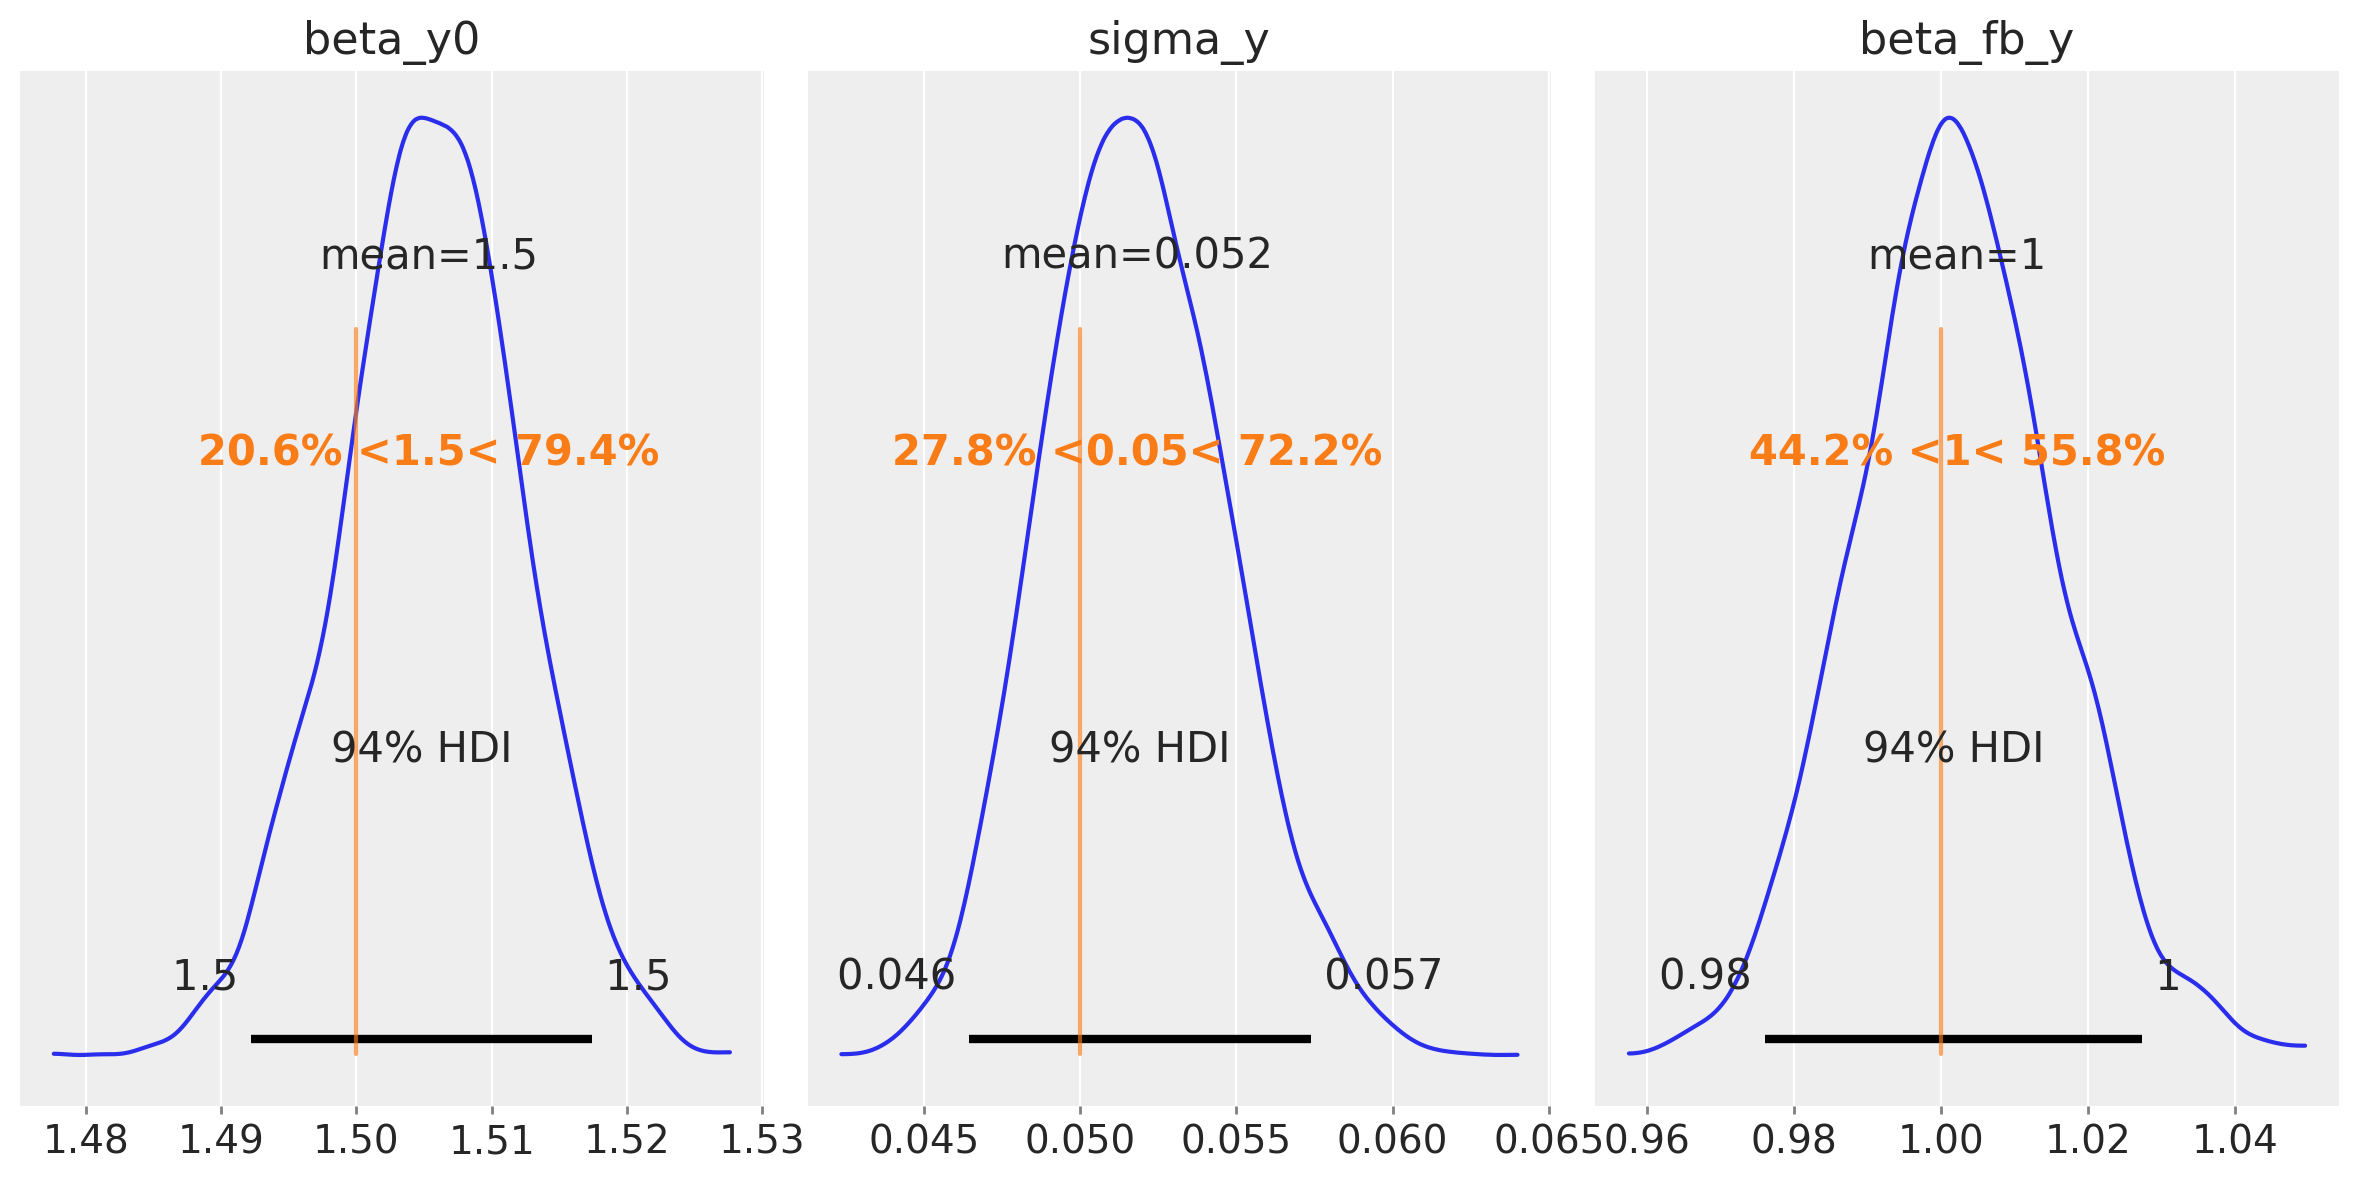

In [337]:
az.plot_posterior(
    mmm.idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

In [338]:
# az.plot_posterior(
#     mmm.idata,
#     var_names=["gamma_dayofweek"],
#     ref_val=dow_gamma_true,
#     figsize=(12, 6),
# )
# plt.tight_layout();

In [339]:
# az.summary(mmm.idata, var_names=list(true_values.keys()) + ["gamma_dayofweek"])

In [340]:
# az.plot_forest(
#     mmm.idata,
#     var_names=["gamma_dayofweek"],
#     combined=True,
#     figsize=(12, 6),
# )

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

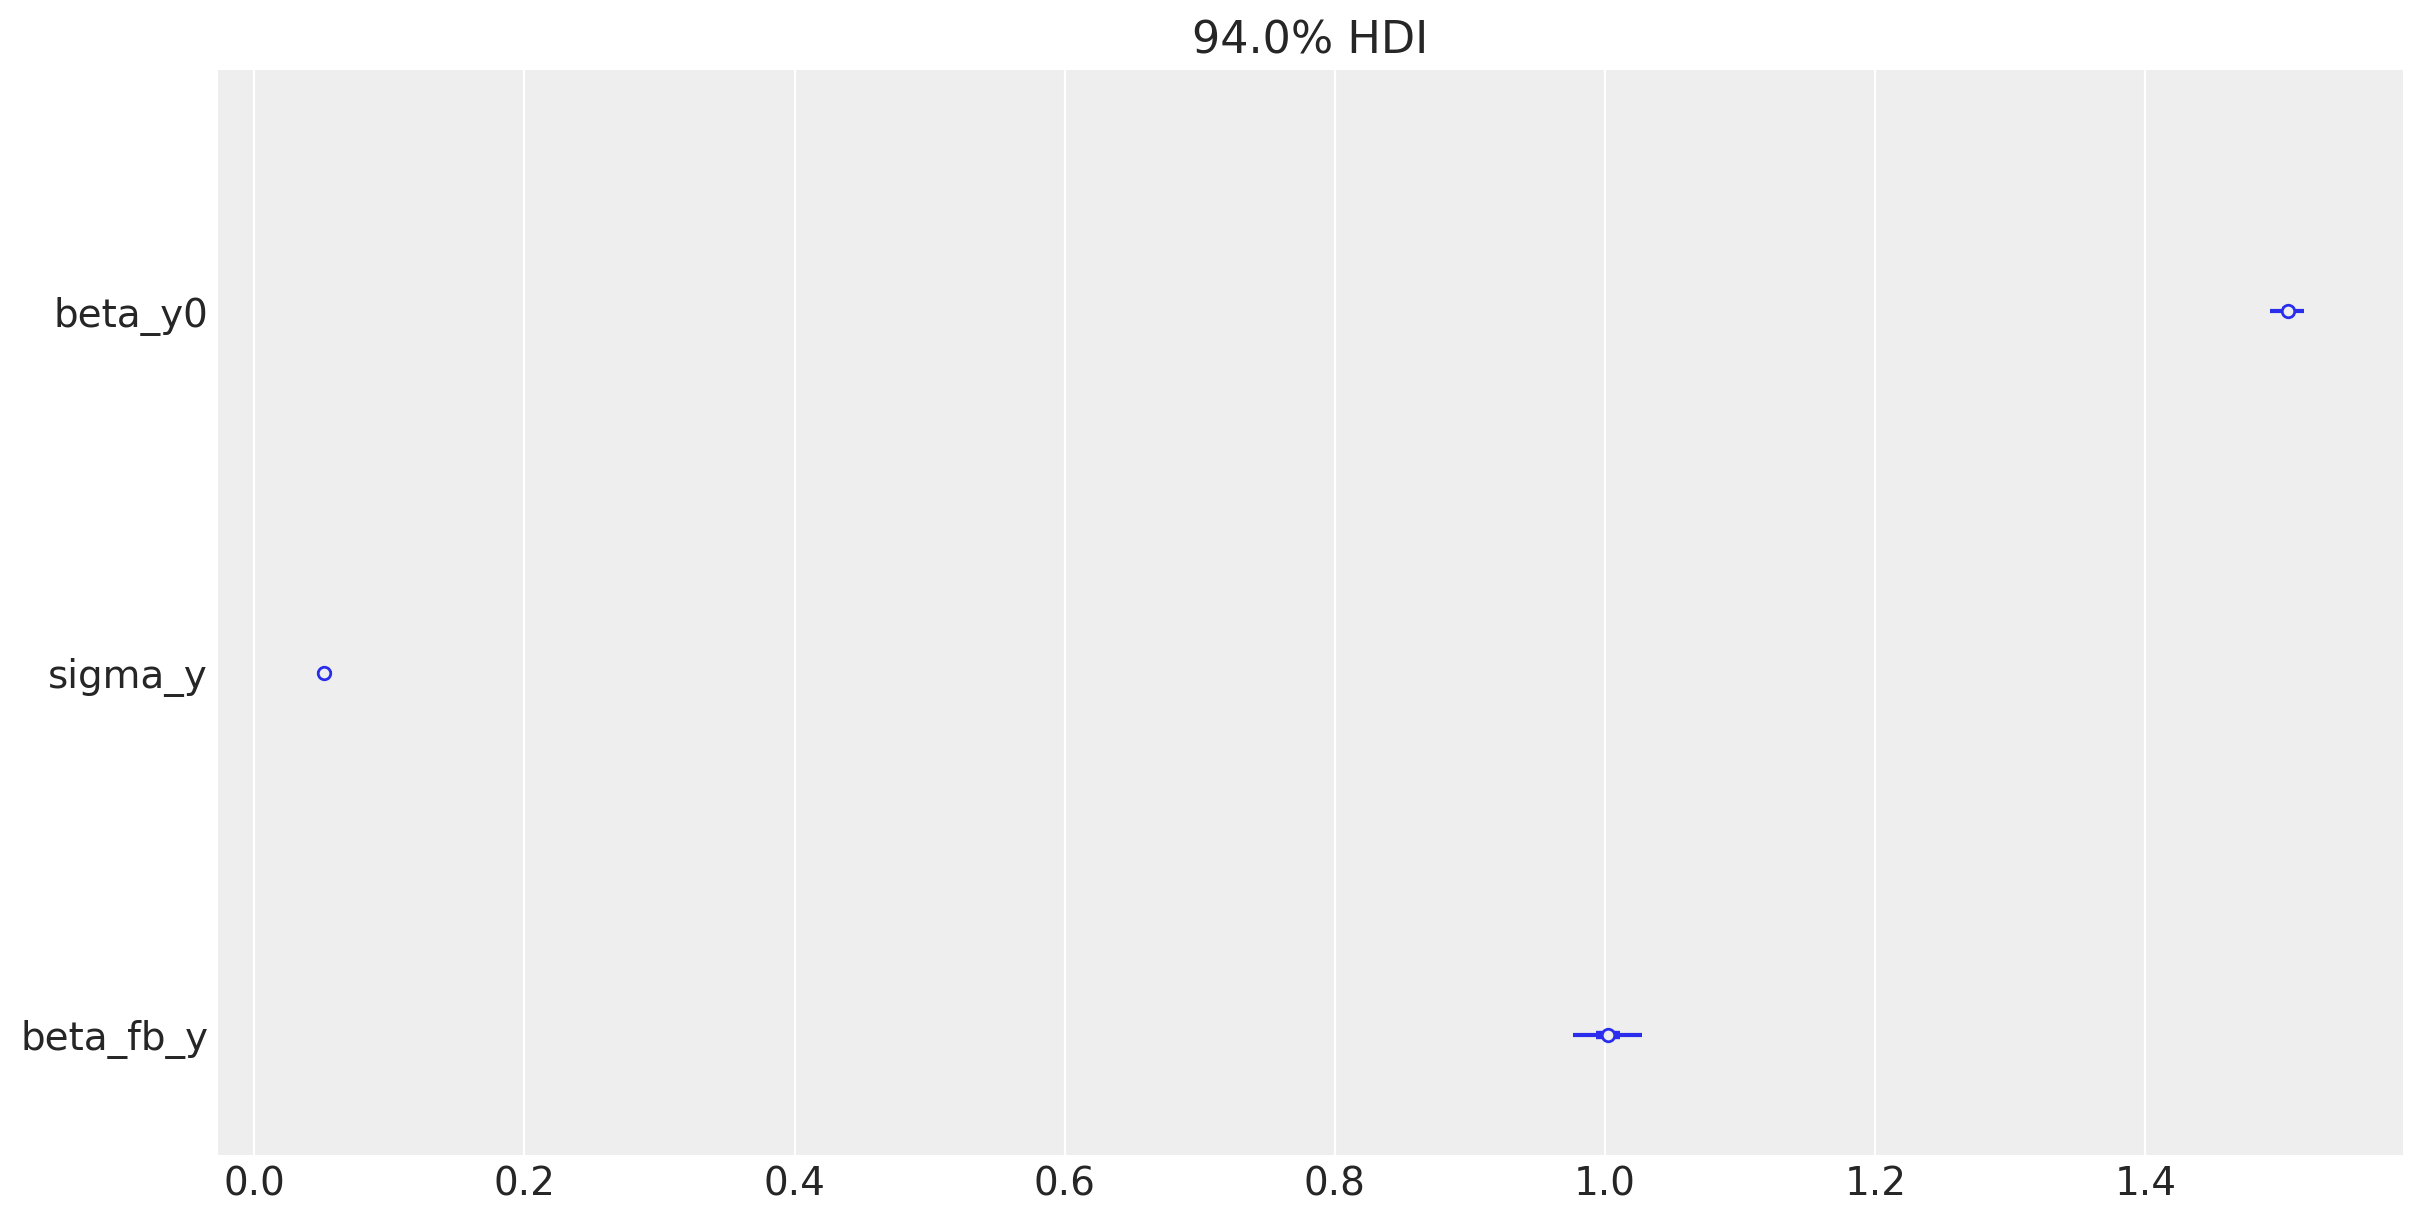

In [341]:
az.plot_forest(
    mmm.idata,
    var_names=list(true_values.keys()),
    combined=True,
    figsize=(12, 6),
)

In [342]:
with mmm.model:
    pp = pm.sample_posterior_predictive(mmm.idata, var_names=["y_mu"])
pp


Sampling: []


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [343]:

plotdata = { 
    "date" : mmm.dates }

extract_vars = ["y_mu"]
for plotvar in extract_vars:
    plotdata[plotvar] = pp.posterior_predictive[plotvar].mean(dim=["chain", "draw"])

# plotdata["ch_sem_org"] = data["ch_sem"]

plotdata_df = pd.DataFrame(plotdata)
plotdata_df


,date,y_mu
0,2024-01-01,1.824656
1,2024-01-02,1.618012
2,2024-01-03,1.798419
3,2024-01-04,1.576932
4,2024-01-05,1.892970
...,...,...
146,2024-05-26,1.622380
147,2024-05-27,1.829867
148,2024-05-28,2.375527
149,2024-05-29,1.614604


Sampling: []


Output()

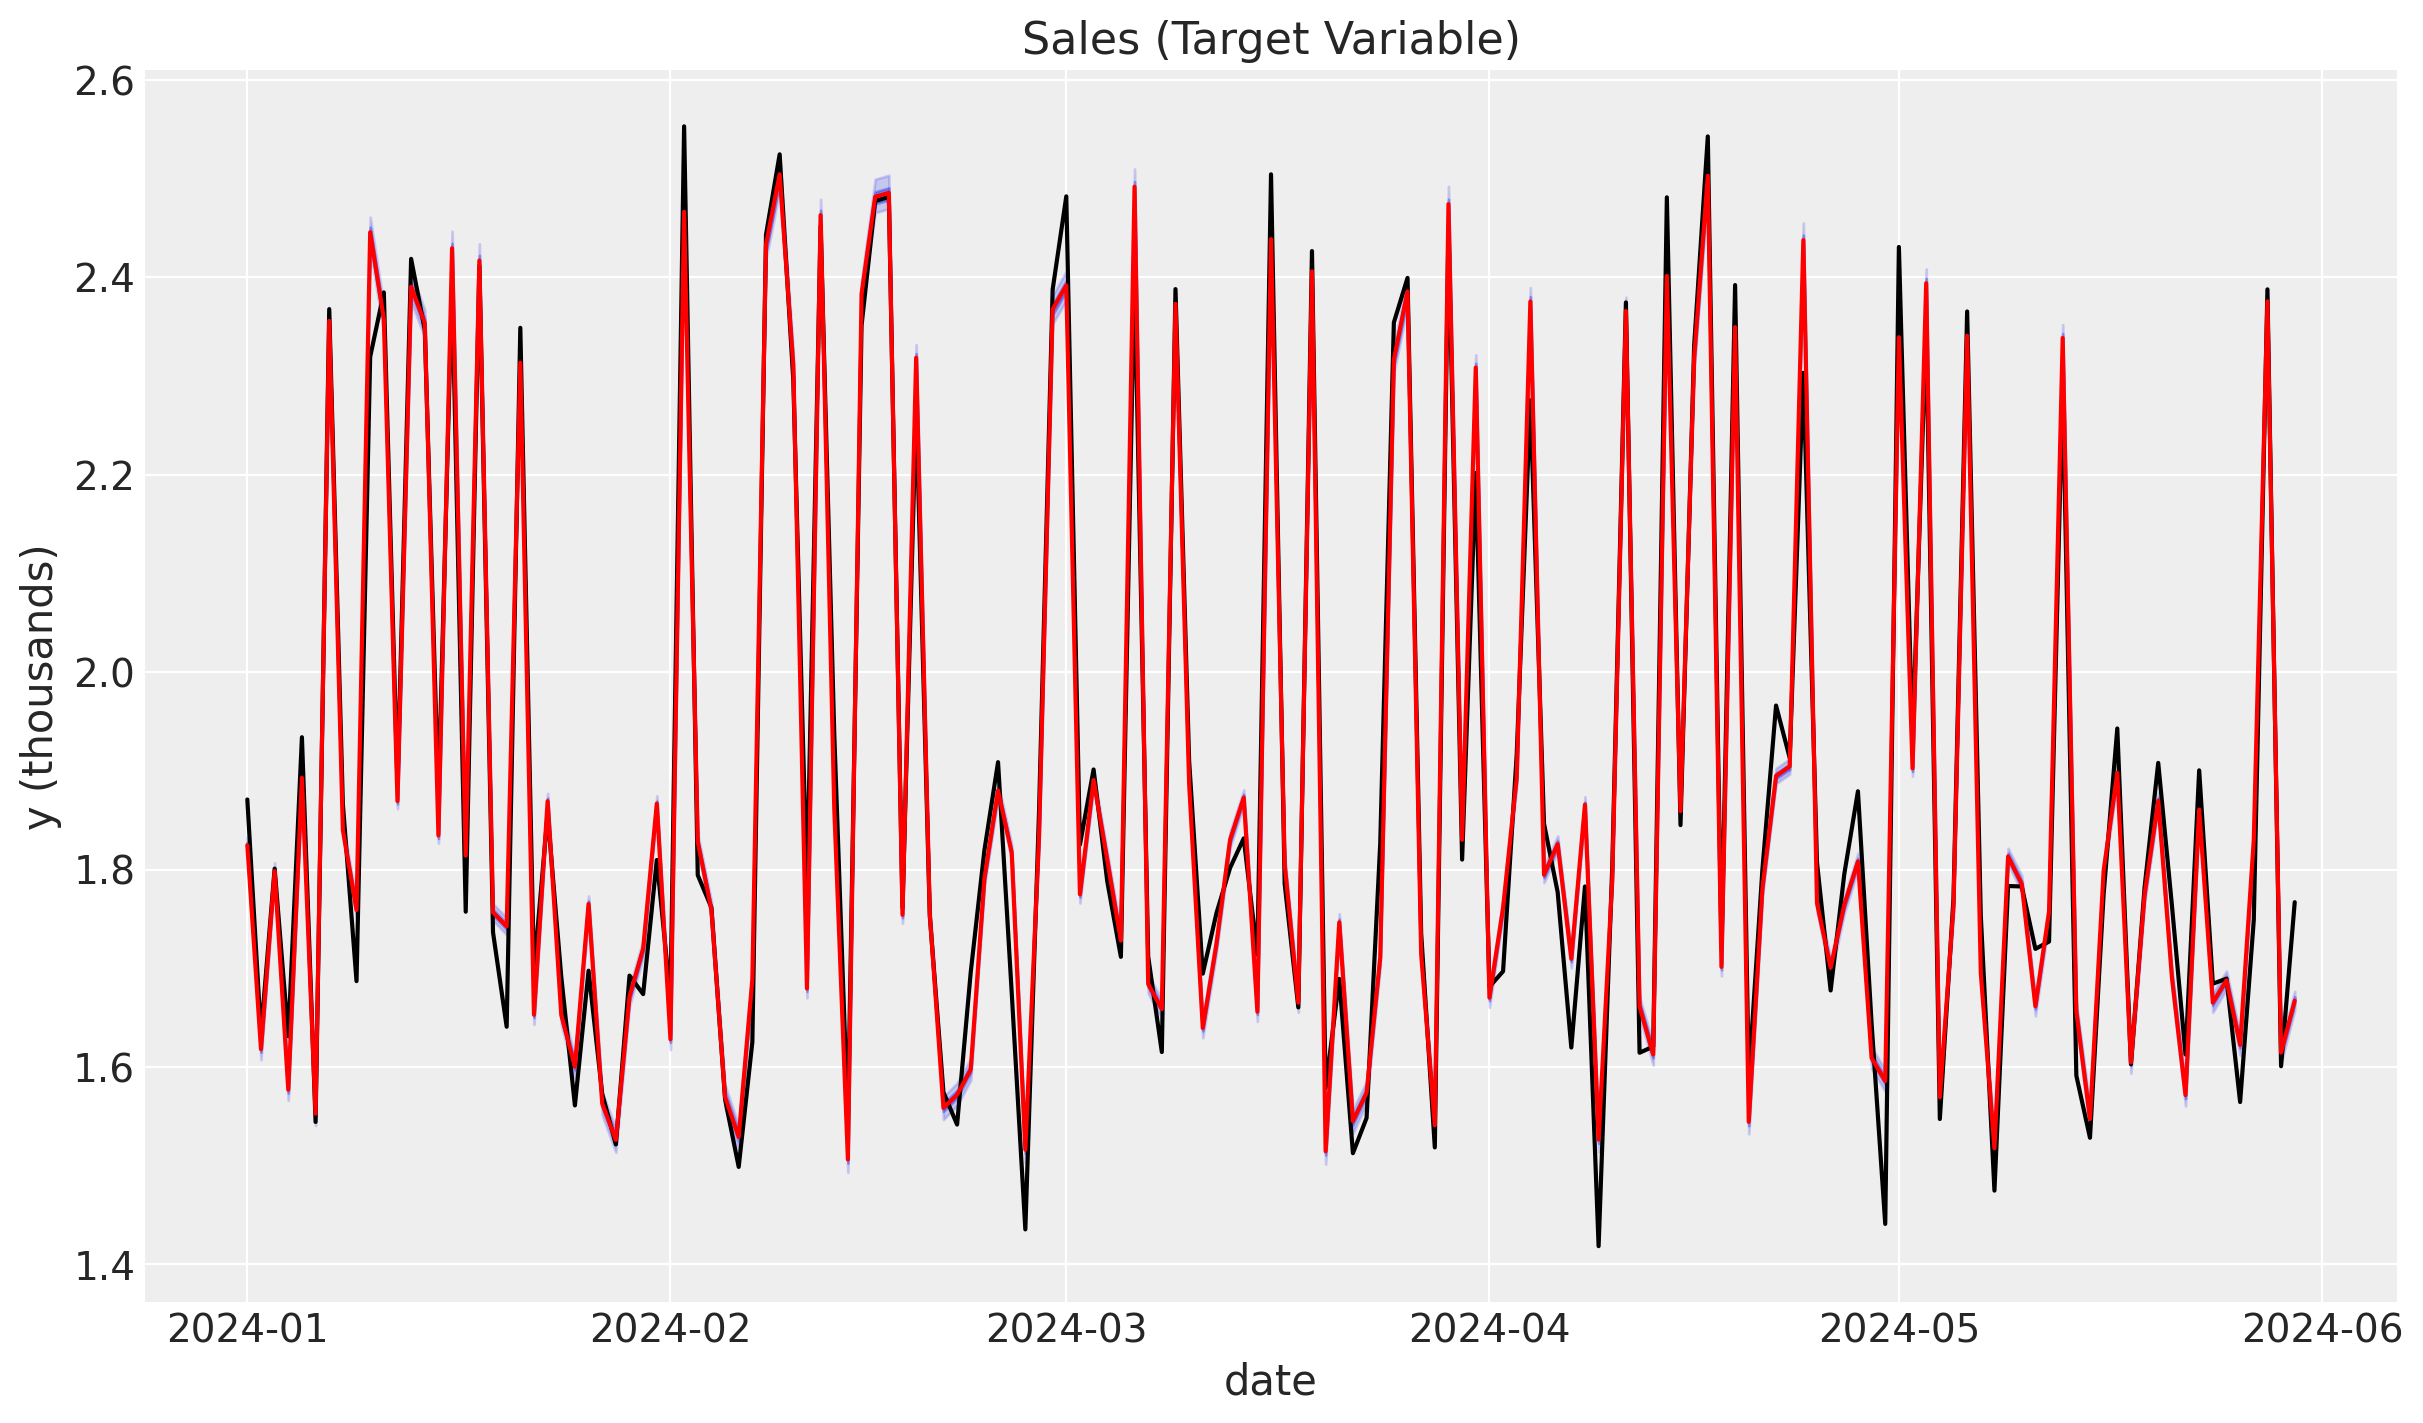

In [344]:
mmm.plot_posterior_predictive()

In [345]:
# mmm.plot_errors()